## RNN을 이용한 SIN 함수 예측

  
과목명 | 금융공학  
교수명 | 안재윤 교수님  
제출일 | 2018년 12월 04일  
  
학　번 | 182STG18  
이　름 | 이하경  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sin(x, T = 100):
    return np.sin(2 * np.pi * x / T)

In [3]:
x = np.arange(1, 6)
sin(x)

array([0.06279052, 0.12533323, 0.18738131, 0.24868989, 0.30901699])

In [4]:
def toy_problem(T = 100, ampl = 0.05):
    x = np.arange(0, 2*T +1) # sequence 0, ..., 200
    noise = ampl * np.random.uniform(low = -1, high = 1, size = len(x))
    return sin(x) + noise

### Generate Real Data

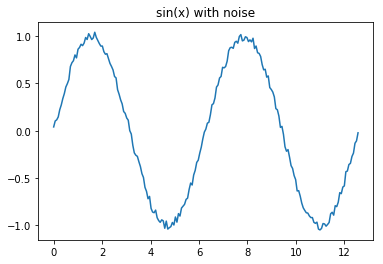

In [5]:
T = 100
f = toy_problem(T)
x = np.arange(0, 2*T +1) *2*np.pi/T # x축 scale 조정

plt.plot(x, f)
plt.title('sin(x) with noise')
plt.show()

In [6]:
seq_length = 25

data = []
target = []

for i in range(0, len(x) - seq_length): # 0부터 175까지 각각의 25개짜리 시퀀스의 시작점
    data.append(f[i:(i+seq_length)])    # t = 0부터 24까지 25개의 data로
    target.append(f[i+seq_length])      # t = 25의 target을 예측
    
X = np.array(data).reshape(len(data), seq_length, 1)
Y = np.array(target).reshape(len(data), 1)

In [7]:
print(X.shape, Y.shape)

(176, 25, 1) (176, 1)


In [8]:
from sklearn.model_selection import train_test_split

N_train = int(len(data) * 0.9)
N_valid = len(data) - N_train

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = N_valid)

In [9]:
print("train.shape:", X_train.shape, Y_train.shape)
print("validation.shape:", X_valid.shape, Y_valid.shape)

train.shape: (158, 25, 1) (158, 1)
validation.shape: (18, 25, 1) (18, 1)


###  Modeling by Tensorflow

In [10]:
n_in = X.shape[-1]  # X의 feature(variable)의 개수 (=1)
n_out = X.shape[-1] # Y의 class의 개수 (=1)

n_hidden = 30      

In [11]:
# placeholders
x = tf.placeholder(tf.float32, [None, seq_length, n_in]) # sequence를 feed
p = tf.placeholder(tf.float32, [None, n_out]) # target을 feed
n_batch = tf.placeholder(tf.int32)

In [12]:
def get_variable(name, shape):
    return tf.get_variable(name, shape, tf.float32,
                           initializer = tf.contrib.layers.xavier_initializer())

### Basic RNN Cell :

In [13]:
# Input Gate
Wxa = get_variable('Wxa', [n_in, n_hidden])        # ~ x(t) [n_batch, n_in]와 곱해지면 [n_batch, n_hidden]이 됨
Waa = get_variable('Waa', [n_hidden, n_hidden])    # ~ a(t-1) [n_batch, n_hidden]와 곱해지면 [n_hidden, n_hidden]이 됨
Wa = tf.concat([Wxa, Waa], axis = 0)               # [n_batch + n_hidden, n_hidden] 차원, [x(t),a(t-1)]와 곱해지면 [n_batch, n_hidden]
ba = get_variable('ba', [n_hidden])                # a(t) = tf.tanh( tf.matmul([x(t),a(t-1)], Wa) + ba )

Way = get_variable('Way', [n_hidden, 1])           # ~ 새로 만들어진 a(t)와 곱해짐 (하나의 output)
by = get_variable('by', [1])                       # tf.tanh( tf.matmul(a(t), Way) + by ) = y_hat(t)_output 이라고 하면 
# Linear
W = get_variable('W', [1, n_out])                  # y_hat(t) = tf.matmul( y_hat(t)_output ) + b
b = get_variable('b', [n_out])

In [14]:
# hidden = a (hidden) state

init_state = tf.zeros([n_batch, n_hidden], tf.float32) # cell.zero_state(n_batch)
state = init_state

y_hats = []
hiddens = []

x_ = tf.unstack(x, axis = 1)                           # [None, n_in] 25개를 풀어서 저장
for t, x_t in enumerate(x_):
    if t == 0:                                         # t = 0일 경우 initial state a(0)를 이용
        xa = tf.concat([x_t, state], axis = 1)         # 차원은 [n_batch, n_batch + n_hidden]
    else:
        xa = tf.concat([x_t, hiddens[t-1]], axis = 1)  # t > 0일 경우 이전 state a(t-1)의 값을 이용
    
    state = tf.tanh( tf.matmul(xa, Wa) + ba )          # = a(t)
    y_hat = tf.tanh( tf.matmul(state, Way) + by )

    hiddens.append(state)                              # a(t)를 저장하여 다음 시점에 사용하기 위함
    y_hats.append(y_hat)                               
    
y_hat_output = y_hats[-1]                              # x(1),...,x(25)으로 y_hat(26) 하나의 값 예측
y = tf.matmul( y_hat_output, W ) + b                   # 최종 linear output

In [15]:
loss = tf.reduce_mean(tf.square(y - p))                # MSE
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999)
train_step = optimizer.minimize(loss)

In [16]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

epochs = 500
batch_size = 10
n_batches = N_train // batch_size

from sklearn.utils import shuffle

my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        sess.run(train_step, feed_dict = {
            x: X_[start:end], p: Y_[start:end], n_batch: batch_size
        })
        val_loss = sess.run(loss, feed_dict = {
            x: X_[start:end], p: Y_[start:end], n_batch: batch_size
        })
        my_loss.append(val_loss)
        
#         if epoch % 10 == 0:
#             print("epoch:", epoch, "current loss:", val_loss)

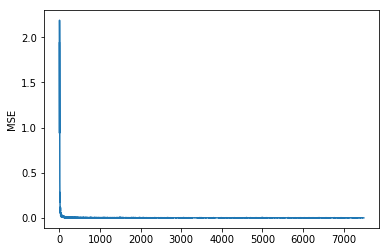

In [29]:
plt.plot(my_loss)
plt.ylabel('MSE')
plt.show()

In [17]:
# train data의 MSE
loss.eval(session = sess, feed_dict = { x: X_train, p: Y_train, n_batch: X_train.shape[0] })

0.0011249053

In [18]:
# validation data의 MSE
loss.eval(session = sess, feed_dict = { x: X_valid, p: Y_valid, n_batch: X_valid.shape[0] }) 

0.000743463

In [19]:
y_pred = y.eval(session = sess, feed_dict = { x: X, p: Y, n_batch: X.shape[0] })
y_pred.shape 

(176, 1)

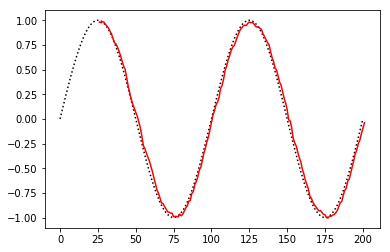

In [20]:
time = np.arange(seq_length+1, (seq_length+X.shape[0]+1))

plt.plot(toy_problem(100, ampl = 0), ':k')
plt.plot(time, y_pred.reshape(y_pred.shape[0]), 'r')
plt.show()

### Modeling by Keras

In [21]:
import keras
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.layers import Activation, Dense

Using TensorFlow backend.


In [22]:
# weight와 bias variable을 정의하기 위한 함수(초기값 할당)

def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.01))
def bias_variable(shape):
    return tf.Variable(tf.zeros(shape))

In [23]:
# modeling을 시작하자
model = Sequential() 

# 가장 간단한 RNN Cell을 만든다
# t 시점에서 x(t)와 이전 시점의 state a(t-1)이 입력되어 a(t)와 y_hat(t)를 출력함

model.add(SimpleRNN(units = n_hidden, init = weight_variable, # state의 shape = [n_batch, n_hidden]
                    input_shape = (seq_length, n_out)))       # input의 shape = [n_batch, 25, 1]

# input과 output을 모두 연결하는 Dense Layer를 만든다
# (RNN Cell에서 output된 y_hat(dim = n_batch)들을 input으로 받아와 최종 output layer(dim = n_out)과 모두 연결)

model.add(Dense(n_out, init = weight_variable))
model.add(Activation("linear")) 
# 두 층 사이의 활성함수는 linear combination (y_hat = y_hat*W + b)

C:\Users\HG\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=30, input_shape=(25, 1), kernel_initializer=<function ...)`
  
C:\Users\HG\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer=<function ...)`
  del sys.path[0]


In [24]:
optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999) 
model.compile(loss = "mean_squared_error", optimizer = optimizer)           

# Adam optimizer의 성능을 높이는 학습률과 상수 설정
# 손실함수로 predicted y와 true y의 MSE 설정

In [25]:
epochs = 500     # 총 학습횟수
batch_size = 10  # mini-batch

model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
          validation_data = (X_valid, Y_valid), verbose = 0)

# 학습마다 158//10 번의 mini-batch를 총 500번 반복학습한다

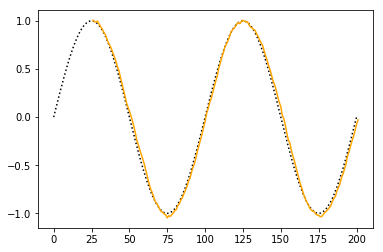

In [26]:
y_pred = model.predict(X)                    # shape는 [len(X), 1]으로 2차원이므로
predicted = y_pred.reshape(y_pred.shape[0])  # 1차원 array로 reshape

plt.plot(toy_problem(T, ampl = 0), ':k')
plt.plot(np.arange(seq_length+1, 2*T+1+1), predicted, 'orange')
plt.show()